### setup

In [2]:
import music21 as m21
import collections
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
filenames = glob.glob('data/note_csvs/*')

In [5]:
note_dfs = []
for file in filenames:
    note_dfs.append(pd.read_csv(file))

In [6]:
len(note_dfs)

31161

### prepare data

In [7]:
pitch_corpus = []
duration_corpus = []

for df in note_dfs:    
    pitch_corpus += list(df['pitch'])
    duration_corpus += list(df['duration'])

/Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

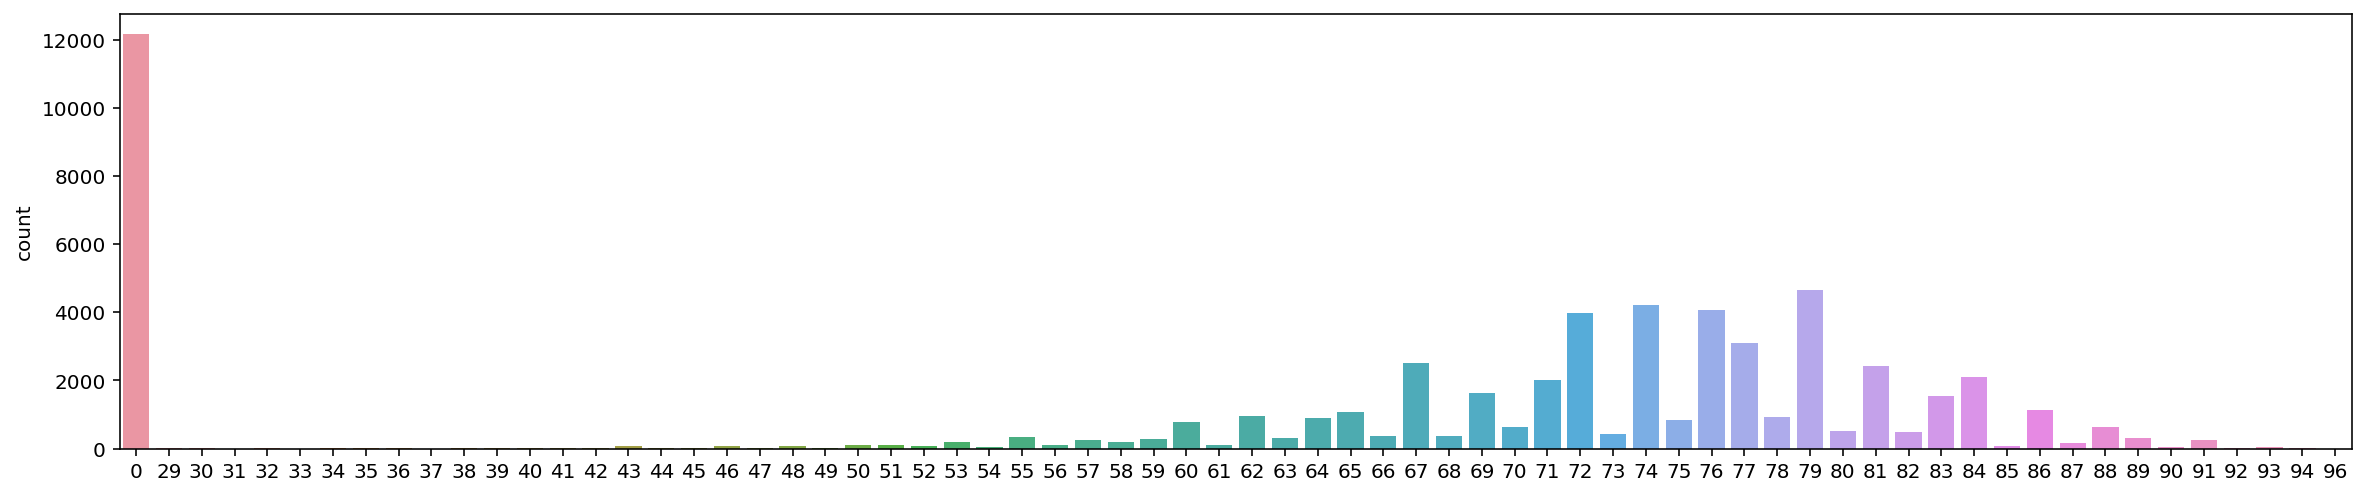

In [8]:
plt.figure(figsize=(20,4))
sns.countplot(pitch_corpus)

/Users/Stephen/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

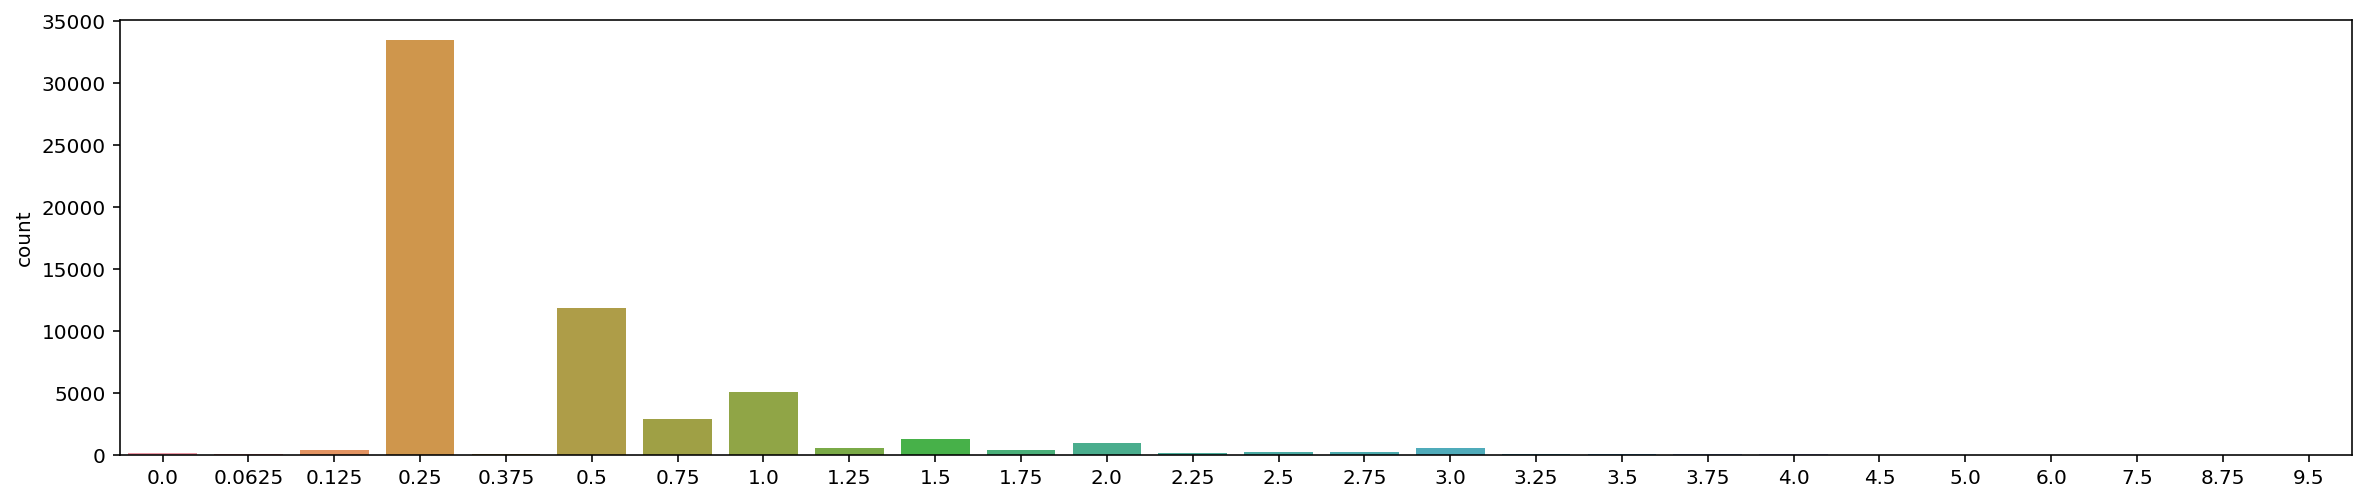

In [9]:
plt.figure(figsize=(20,4))
sns.countplot(duration_corpus)

In [10]:
pitch_count_num = collections.Counter(pitch_corpus)
duration_count_num = collections.Counter(duration_corpus)

print("Total notes in dataset:", len(pitch_corpus))
print("Total unique pitches in corpus:", len(pitch_count_num))
print("Total unique durations in corpus:", len(duration_count_num))

Total notes in dataset: 57980
Total unique pitches in corpus: 68
Total unique durations in corpus: 26


In [11]:
# Exploring the notes dictionary
Notes = list(pitch_count_num.keys())
Recurrence = list(pitch_count_num.values())

# Average recurrence for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 852.6470588235294
Most frequent note in Corpus appeared: 12153 times
Least frequent note in Corpus appeared: 2 time


In [12]:
# Storing all the unique characters present in the corpus to buid a mapping dict.
pitch_symb = sorted(list(set(pitch_corpus)))
duration_symb = sorted(list(set(duration_corpus)))

L_pitch_corpus = len(pitch_corpus)  # length of corpus
L_duration_corpus = len(duration_corpus)
L_pitch_symb = len(pitch_symb)  # length of total unique characters
L_duration_symb = len(duration_symb)

# Building dictionary to access the vocabulary from indices and vice versa
pitch_mapping = dict((int(c), i) for i, c in enumerate(pitch_symb))
pitch_reverse_mapping = dict((i, int(c)) for i, c in enumerate(pitch_symb))
duration_mapping = dict((float(c), i) for i, c in enumerate(duration_symb))
duration_reverse_mapping = dict((i, float(c)) for i, c in enumerate(duration_symb))

print("Total number of pitches:", L_pitch_corpus)
print("Number of unique pitches:", L_pitch_symb)
print("Total number of durations:", L_duration_corpus)
print("Number of unique durations:", L_duration_symb)

Total number of pitches: 57980
Number of unique pitches: 68
Total number of durations: 57980
Number of unique durations: 26


In [264]:
# Splitting the corpus in equal length of strings and output target
length = 15
features = []
target_pitch = []
target_duration = []
for df in note_dfs:
    L_df = len(df)
    if L_df <= length:
        continue
#     print(f"length of df: {L_df}")
    for i in range(0, L_df - length, 1):
        feature = df[i:i+length][['pitch', 'duration']]
        feature_list = []
        for ind, val in feature.iterrows():
            feature_list.append([int(val.pitch), float(val.duration)])
        feature_mapped = [[pitch_mapping[val[0]], duration_mapping[val[1]]] for val in feature_list]
        features.append(feature_mapped)
        
        target_pitch.append(pitch_mapping[df['pitch'][i + length]])
        target_duration.append(duration_mapping[df['duration'][i + length]])
            
L_datapoints = len(target_pitch)
print("Total number of sequences in the corpus:", L_datapoints)

Total number of sequences in the corpus: 26014


**preparing X and y**

In [265]:
# reshape X
X = (np.reshape(features, (L_datapoints, length, 2)))
# normalize X
X_norm = np.zeros(X.shape[0]*X.shape[1]*X.shape[2]).reshape(X.shape)
X_norm[:, :, 0] = X[:, :, 0] / float(L_pitch_symb)
X_norm[:, :, 1] = X[:, :, 1] / float(L_duration_symb)

X_norm.shape

(26014, 15, 2)

In [266]:
y_pitch = np.array(target_pitch).reshape(-1,1)
y_duration = np.array(target_duration).reshape(-1,1)
y = {"pitch_output": y_pitch, "duration_output": y_duration}

y_pitch.shape

(26014, 1)

**getting class weights and preparing sample weights**

In [206]:
# class weights
pitch_counts = np.unique(np.array(target_pitch), return_counts=True)
duration_counts = np.unique(np.array(target_duration), return_counts=True)

pitch_class_weights_simple = {key:val for key, val in zip(pitch_counts[0], pitch_counts[1])}
duration_class_weights_simple = {key:val for key, val in zip(duration_counts[0], duration_counts[1])}
pitch_mean = np.mean(list(pitch_class_weights_simple.values()))
duration_mean = np.mean(list(duration_class_weights_simple.values()))
pitch_class_weights = {key:(1 / val) * pitch_mean for key, val in zip(pitch_counts[0], pitch_counts[1])}
duration_class_weights = {key:(1 / val) * duration_mean for key, val in zip(duration_counts[0], duration_counts[1])}

pcw = pitch_class_weights
dcw = duration_class_weights

pcw_keys = list(pitch_class_weights)
dcw_keys = list(duration_class_weights)

for i in range(max(pcw_keys)):
    if i not in pcw_keys:
        pcw[i] = 0

for i in range(max(dcw_keys)):
    if i not in dcw_keys:
        dcw[i] = 0

In [207]:
print(len(pcw))
print(len(dcw))

68
25


In [208]:
# sample weights
y_pitch_cw = np.array([pcw[pitch] for pitch in y_pitch[:, 0]])
y_dur_cw = np.array([dcw[dur] for dur in y_duration[:, 0]])

sample_weight = ((y_pitch_cw + y_dur_cw) / 2).reshape(-1, 1)
sample_weight.shape

(31891, 1)

In [272]:
X_norm[0].shape

(15, 2)

### modeling

In [276]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

def initialize_dense_model():
    input_layer = Input(shape=X_norm.shape[1:], name='input_layer')
    reshape_layer = Reshape((X_norm.shape[-1] * X_norm.shape[-2],))(input_layer)
    first_dense = Dense(32, name='first_dense', activation='relu')(reshape_layer)
    hidden_dense = Dense(16, name='hidden_dense', activation='relu')(first_dense)
    pitch_output = Dense(len(pcw), name='pitch_output', activation='softmax')(hidden_dense)
    duration_output = Dense(len(dcw), name='duration_output', activation='softmax')(hidden_dense)
    
    model = Model(inputs=input_layer, outputs=[pitch_output, duration_output])

    losses = {
        "pitch_output": "sparse_categorical_crossentropy",
        "duration_output": "sparse_categorical_crossentropy",
    }

    loss_weights = {
        "pitch_output": 1.0, 
        "duration_output": 1.0
    }

    model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics = metric)
    
    return model

In [277]:
model = initialize_dense_model()
model.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 15, 2)]      0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 30)           0           input_layer[0][0]                
__________________________________________________________________________________________________
first_dense (Dense)             (None, 32)           992         reshape_1[0][0]                  
__________________________________________________________________________________________________
hidden_dense (Dense)            (None, 16)           528         first_dense[0][0]                
______________________________________________________________________________________

In [280]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_norm, 
                    y, 
                    validation_split=0.2, 
                    shuffle=True, 
                    batch_size=16, 
                    epochs=500, 
                    verbose=1, 
#                     callbacks=[es], 
                    sample_weight=sample_weight)

Epoch 1/500
1301/1301 [==============================] - 7s 5ms/step - loss: 3.5325 - pitch_output_loss: 2.7617 - duration_output_loss: 0.7708 - pitch_output_sparse_top_k_categorical_accuracy: 0.3615 - duration_output_sparse_top_k_categorical_accuracy: 0.9357 - val_loss: 3.0402 - val_pitch_output_loss: 1.7684 - val_duration_output_loss: 1.2718 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3306 - val_duration_output_sparse_top_k_categorical_accuracy: 0.7988
Epoch 2/500
1301/1301 [==============================] - 6s 5ms/step - loss: 3.4859 - pitch_output_loss: 2.7258 - duration_output_loss: 0.7601 - pitch_output_sparse_top_k_categorical_accuracy: 0.3582 - duration_output_sparse_top_k_categorical_accuracy: 0.9357 - val_loss: 3.1214 - val_pitch_output_loss: 1.7690 - val_duration_output_loss: 1.3524 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3267 - val_duration_output_sparse_top_k_categorical_accuracy: 0.8011
Epoch 3/500
1301/1301 [==============================] - 6

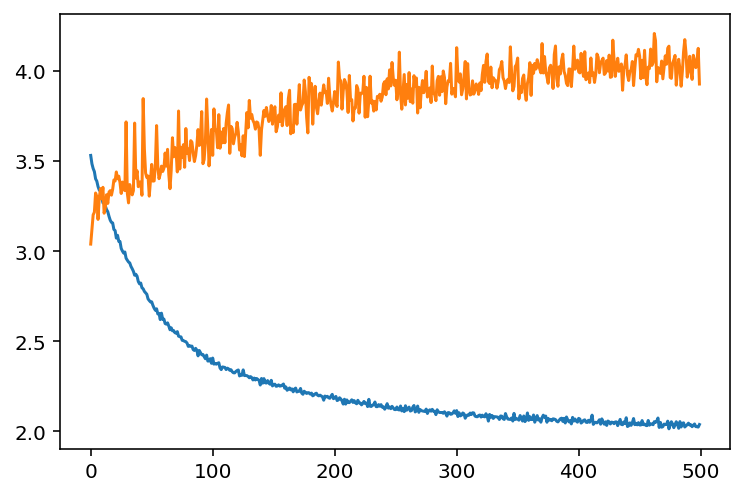

In [281]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss']);

In [227]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

opt = Adam(learning_rate=0.001)
metric = SparseTopKCategoricalAccuracy(k=3, name='sparse_top_k_categorical_accuracy')

def initialize_model():
    
    input_layer = Input(shape=X_norm.shape[1:], name='input_layer')
    first_LSTM = LSTM(64, name='first_LSTM', activation='tanh', return_sequences=True)(input_layer)
#     first_dropout = Dropout(0.1, name='first_dropout')(first_LSTM)

    pitch_LSTM = LSTM(64, name='pitch_LSTM', activation='tanh')(first_LSTM)
    pitch_dropout = Dropout(0.2, name='pitch_dropout')(pitch_LSTM)
    pitch_dense = Dense(32, name='pitch_dense', activation='tanh')(pitch_dropout)
    pitch_dropout_2 = Dropout(0.4, name='pitch_dropout_2')(pitch_dense)
    pitch_output = Dense(len(pcw), name='pitch_output', activation='softmax')(pitch_dropout_2)


    duration_LSTM = LSTM(32, name='duration_LSTM', activation='tanh')(first_LSTM)
    duration_dropout = Dropout(0.2, name='duration_dropout')(duration_LSTM)
    duration_dense = Dense(16, name='duration_dense', activation='tanh')(duration_dropout)
    duration_dropout_2 = Dropout(0.4, name='duration_dropout_2')(duration_dense)
    duration_output = Dense(len(dcw), name='duration_output', activation='softmax')(duration_dropout_2)

    model = Model(inputs=input_layer, outputs=[pitch_output, duration_output])

    losses = {
        "pitch_output": "sparse_categorical_crossentropy",
        "duration_output": "sparse_categorical_crossentropy",
    }

    loss_weights = {
        "pitch_output": 1.0, 
        "duration_output": 1.0
    }

    model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics = metric)

    return model

In [228]:
model = initialize_model()
model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 8, 2)]       0                                            
__________________________________________________________________________________________________
first_LSTM (LSTM)               (None, 8, 64)        17152       input_layer[0][0]                
__________________________________________________________________________________________________
pitch_LSTM (LSTM)               (None, 64)           33024       first_LSTM[0][0]                 
__________________________________________________________________________________________________
duration_LSTM (LSTM)            (None, 32)           12416       first_LSTM[0][0]                 
______________________________________________________________________________________

In [162]:
from tensorflow.keras.utils import plot_model
plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [229]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_norm, 
                    y, 
                    validation_split=0.2, 
                    shuffle=True, 
                    batch_size=16, 
                    epochs=500, 
                    verbose=1, 
                    callbacks=[es], 
                    sample_weight=sample_weight)

Epoch 1/500
1595/1595 [==============================] - 23s 15ms/step - loss: 6.1117 - pitch_output_loss: 3.5588 - duration_output_loss: 2.5529 - pitch_output_sparse_top_k_categorical_accuracy: 0.2914 - duration_output_sparse_top_k_categorical_accuracy: 0.8812 - val_loss: 10.0647 - val_pitch_output_loss: 5.0642 - val_duration_output_loss: 5.0005 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3157 - val_duration_output_sparse_top_k_categorical_accuracy: 0.8037
Epoch 2/500
1595/1595 [==============================] - 21s 13ms/step - loss: 5.8585 - pitch_output_loss: 3.3890 - duration_output_loss: 2.4695 - pitch_output_sparse_top_k_categorical_accuracy: 0.3071 - duration_output_sparse_top_k_categorical_accuracy: 0.9137 - val_loss: 10.0463 - val_pitch_output_loss: 5.4264 - val_duration_output_loss: 4.6199 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2386 - val_duration_output_sparse_top_k_categorical_accuracy: 0.8009
Epoch 3/500
1595/1595 [=============================

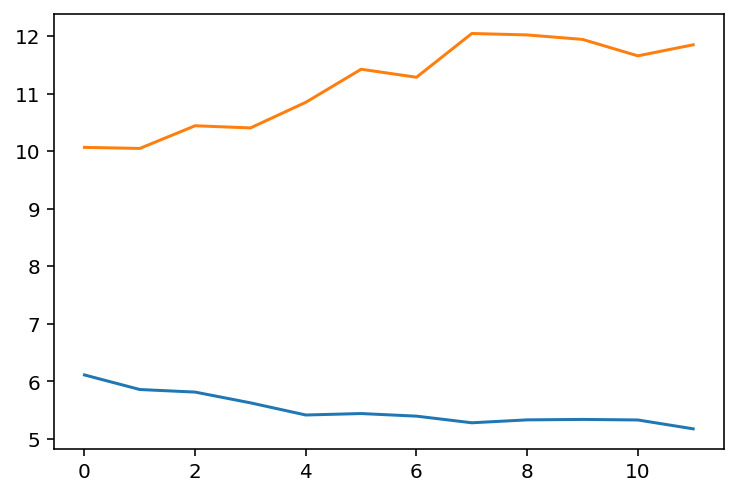

In [230]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss']);

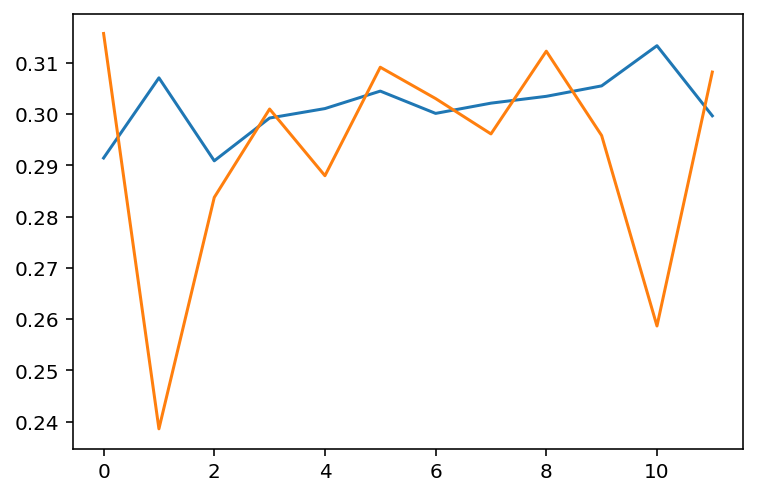

In [231]:
plt.plot(history.epoch, history.history['pitch_output_sparse_top_k_categorical_accuracy'])
plt.plot(history.epoch, history.history['val_pitch_output_sparse_top_k_categorical_accuracy']);

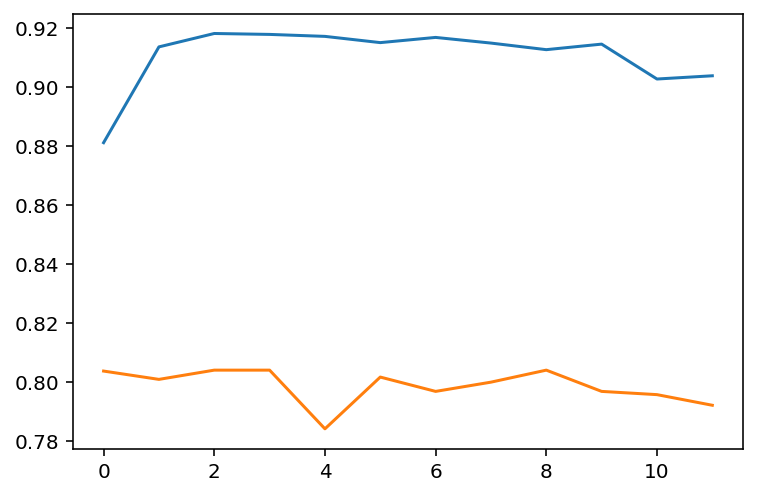

In [232]:
plt.plot(history.epoch, history.history['duration_output_sparse_top_k_categorical_accuracy'])
plt.plot(history.epoch, history.history['val_duration_output_sparse_top_k_categorical_accuracy']);

**generate notes**

In [171]:
note_count = 5
note_choices = []
Music = []
notes_generated = []
sample = X_norm[0].reshape(1, length, 2)
for i in range(note_count):

    # return predictions from sample
    pitch_pred, duration_pred = model.predict(sample)

    # get log of predictions
    pitch_pred = np.log(pitch_pred[0]) / 1.0  # diversity?
    duration_pred = np.log(duration_pred[0])

    # un-log predictions (not sure why we logged them...)
    exp_pitch_preds = np.exp(pitch_pred)
    exp_duration_preds = np.exp(duration_pred)

    # make odds of all predictions = 1.0
    pitch_pred = exp_pitch_preds / np.sum(exp_pitch_preds)
    duration_pred = exp_duration_preds / np.sum(exp_duration_preds)

    # get top 3 pitch predictions and top 2 duration predictions
    pitch_index_top_3 = np.argpartition(pitch_pred, -3)[-3:]
    dur_index_top_2 = np.argpartition(duration_pred, -2)[-2:]

    # return three notes as [pitch, duration] pairs
    three_notes = [[pitch, np.random.choice(dur_index_top_2)] for pitch in pitch_index_top_3]
    three_notes_mapped = [[pitch_reverse_mapping[pitch], duration_reverse_mapping[duration]] for pitch, duration in three_notes]    
    note_choices.append(three_notes_mapped)

    print(three_notes_mapped)
    choice = input('choose 0, 1, or 2:')

    next_note = three_notes_mapped[int(choice)]
    Music.append(next_note)

    next_note_mapped = [pitch_mapping[next_note[0]], duration_mapping[next_note[1]]]
    notes_generated.append(next_note_mapped)

    next_note_norm = [next_note_mapped[0] / float(L_pitch_symb), next_note_mapped[1] / float(L_duration_symb)]
    sample = np.insert(sample[0], len(sample[0]), next_note_norm, axis=0)[1:].reshape(1, length, 2)



[[48, 2.75], [70, 1.5], [83, 1.5]]
choose 0, 1, or 2:0
[[48, 2.75], [70, 1.5], [83, 1.5]]
choose 0, 1, or 2:1
[[70, 1.5], [83, 1.5], [61, 2.75]]
choose 0, 1, or 2:2
[[70, 2.75], [83, 2.75], [61, 1.5]]
choose 0, 1, or 2:0
[[48, 2.75], [61, 1.5], [83, 2.75]]
choose 0, 1, or 2:1


In [172]:
Music

[[48, 2.75], [70, 1.5], [61, 2.75], [70, 2.75], [61, 1.5]]

### useful code

In [ ]:
s = m21.corpus.parse('bach/bwv65.2.xml')

s.analyze('key')

f = m21.note.Note("F5")
f

f.pitch.frequency

bflat = m21.pitch.Pitch('b-4')

bflat.unicodeName

haydn = m21.corpus.getComposer('haydn')

mozart = m21.corpus.getComposer('mozart')

song = m21.instrument.partitionByInstrument(s)

In [ ]:
mozart_1 = m21.corpus.search('mozart')[3].parse()

mozart_1.show('midi')